# Chatbot with Memory Collection

## Review

We built a simple chatbot that saves memories ["in the hot path"](https://langchain-ai.github.io/langgraph/concepts/memory/#writing-memories-in-the-hot-path), as the user is chatting with it

We used the [LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) to store and retrieve memories *across threads*. 

## Goals

Our chatbot saved memories in the simplest possible way, based upon a user-provided keyword ("remember") as raw messages saved to the [store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore).

But saving memories as raw messages with a user-triggered keyword is not ideal! [Managing memories](https://langchain-ai.github.io/langgraph/concepts/memory/#managing-memories) is a central concept, which has at least two dimensions: 

1. *What is the schema* of the memories?
2. *How* are memories updated?

Here, we'll extend our chatbot by saving memories using a [structured schema](https://python.langchain.com/docs/concepts/structured_outputs/#schema-definition) rather than raw messages.

And we'll update memories [as a collection](https://langchain-ai.github.io/langgraph/concepts/memory/#manage-a-collection-of-memories), simply adding to the existing collection as we learn more about the user. 

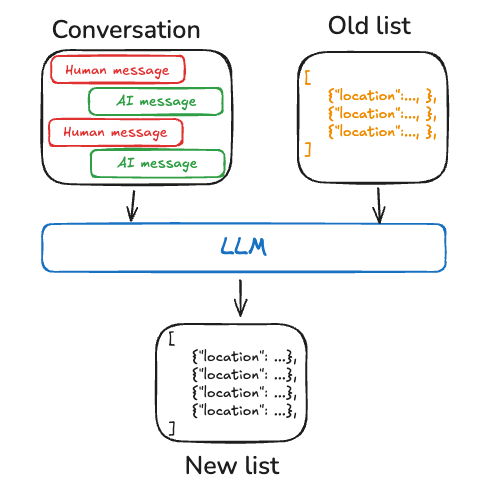

In [10]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [11]:
os.environ["LANGCHAIN_API_KEY"] = "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"

## Defining a memory schema

The [LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) supports any schema for the `value` part of the key-value pair. 

This allows you to store structured information in the memory store. 

One common approach is to define a single schema that will be [updated with new information as the chatbot interacts with the user](https://langchain-ai.github.io/langgraph/concepts/memory/#managing-memories). 

For example, this can be a single user profile. 


Python has many different types for [structured data](https://python.langchain.com/docs/concepts/structured_outputs/#schema-definition). 

### JSON Schema

The simplest and most common format for structured output is a JSON-like structure.

In Python, this can be represented as a dictionary (dict) or list (list). 

JSON objects (or dicts in Python) are often used directly when the tool requires raw, flexible, and minimal-overhead structured data.


In [3]:
# JSON Schema
simple_user_schema = {
"type": "object",
"properties": {
    "content": {
        "type": "string",
        "description": "The main content of the memory. For example: User expressed interest in learning about French."
    },
    "context": {
        "type": "array",
        "items": {"type": "string"},
        "description": "Additional context for the memory. For example: This was mentioned while discussing career options in Europe.",
    }
}
}


Each field has a `type` and a `description`.

We can create an instance of this schema and save it to the memory store.

### Pydantic Schema

As a second example, [Pydantic](https://docs.pydantic.dev/latest/) is particularly useful for defining structured output schemas.

It offers type hints and validation. Here's an example of a Pydantic schema:

In [2]:
# Pydantic Schema

from pydantic import BaseModel, Field
class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")
    context: str = Field(description="Additional context for the memory. For example: This was mentioned while discussing career options in Europe.")

### Saving a schema to the store

Let's save an instance of this schema to the memory store.

In [4]:
# JSON Schema
user_instance_json = {
    "content": "I'm Lance",
    "context": "Mentioned as an introduction to the chat."
}

# Pydantic Schema
user_instance_pydantic = Memory(content="I'm Lance", 
                                context="Mentioned as an introduction to the chat.")

We use the [put](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.put) method to save an object to the store by namespace and key.

In [5]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())
value = user_instance_json
in_memory_store.put(namespace_for_memory, key, value)

In [6]:
key = str(uuid.uuid4())
value = user_instance_pydantic
in_memory_store.put(namespace_for_memory, key, value)

We use [search](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search) to retrieve objects from the store by namespace.

We can see that the different schemas are saved their own keys.

In [7]:
# Search 
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'value': {'content': "I'm Lance", 'context': 'Mentioned as an introduction to the chat.'}, 'key': 'acada59a-7d33-4665-bc29-b472b2fc9f80', 'namespace': ['1', 'memories'], 'created_at': '2024-10-23T23:44:48.772913+00:00', 'updated_at': '2024-10-23T23:44:48.772917+00:00'}
{'value': Memory(content="I'm Lance", context='Mentioned as an introduction to the chat.'), 'key': '5937db68-8964-4392-a98c-c03ce1b436c9', 'namespace': ['1', 'memories'], 'created_at': '2024-10-23T23:44:50.714048+00:00', 'updated_at': '2024-10-23T23:44:50.714050+00:00'}


## Generating memories with a schema

Previously, we did something extremely simple! 

We just wrote the user's raw chat message (string) to the memory store if it contained the keyword "remember"!

```python
# Get the last message from the user 
last_message = state["messages"][-1]

# Check if it contains the keyword "remember"
if "remember" in last_message.content.lower():
    
    # If so, save the message to the store
    store.put(namespace, str(uuid.uuid4()), {"data": last_message.content})
```

But this approach is not idea: 

First, it requires the user to explicitly tell the chatbot to remember something.

Second, it stores the raw message, which may contain extraneous information, and does not adhere to any schema.

We need a way to address these, letting the chatbot choose when to save memories and *extract* the structured information from the message(s) into any memory schema!

This is where the concept of [tool calling](https://python.langchain.com/docs/concepts/tool_calling/) comes into play.

We can bind a desired memory schema as a [tool](https://python.langchain.com/docs/concepts/tools/). 

The model choose to invoke the tool, producing a structured output as specified in the tool definition.

In [12]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Bind Memory schema as a tool to the model
model_with_tools = model.bind_tools([Memory])

# Invoke the model
output = model_with_tools.invoke([HumanMessage("Hi!.")])
output.pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you today?


In [13]:
# Invoke the model with personal information, which should trigger the tool call
output = model_with_tools.invoke([HumanMessage("My name is Lance, I like to bike.")])
output.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_sP04oSpHzAgx1sLbNmvq2z7E)
 Call ID: call_sP04oSpHzAgx1sLbNmvq2z7E
  Args:
    content: User likes to bike.
    context: User introduced themselves as Lance.


In [14]:
output.tool_calls[0]

{'name': 'Memory',
 'args': {'content': 'User likes to bike.',
  'context': 'User introduced themselves as Lance.'},
 'id': 'call_sP04oSpHzAgx1sLbNmvq2z7E',
 'type': 'tool_call'}

In [15]:
# Save to the store
key = str(uuid.uuid4())
value = output.tool_calls[0]["args"]
in_memory_store.put(namespace_for_memory, key, value)

# Search for all memories
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'value': {'content': "I'm Lance", 'context': 'Mentioned as an introduction to the chat.'}, 'key': 'acada59a-7d33-4665-bc29-b472b2fc9f80', 'namespace': ['1', 'memories'], 'created_at': '2024-10-23T23:44:48.772913+00:00', 'updated_at': '2024-10-23T23:44:48.772917+00:00'}
{'value': Memory(content="I'm Lance", context='Mentioned as an introduction to the chat.'), 'key': '5937db68-8964-4392-a98c-c03ce1b436c9', 'namespace': ['1', 'memories'], 'created_at': '2024-10-23T23:44:50.714048+00:00', 'updated_at': '2024-10-23T23:44:50.714050+00:00'}
{'value': {'content': 'User likes to bike.', 'context': 'User introduced themselves as Lance.'}, 'key': '66200d82-5d04-4e17-9c2f-1beb93649093', 'namespace': ['1', 'memories'], 'created_at': '2024-10-23T23:45:46.826890+00:00', 'updated_at': '2024-10-23T23:45:46.826893+00:00'}


## Managing a memory collection with our chatbot

Now, we can bring this all together and improve our chatbot in a few ways: 

First, it will decide when to save memories.

Second, it will extract the structured information from the message(s) into the specified memory schema.

Third, it will save the memories as a collection, updating the existing collection as we learn more about the user.

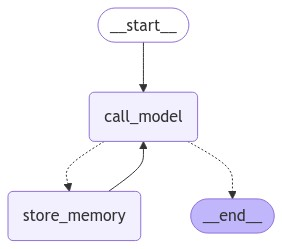

In [16]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Call the model with the system prompt that contains the memories as well as the user's messages."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the most recent memories for context
    memories = store.search(namespace)

    # Format the memories for the system prompt
    info = "\n".join(f"[{mem.key}]: {mem.value}" for mem in memories)
    system_msg = f"""You are a helpful assistant talking to the user.  
    Save any relevant information as a memory.
    Here are existing memories: {info}"""

    # Invoke the model with the system prompt that contains the memories as well as the user's messages
    response = model_with_tools.invoke([SystemMessage(content=system_msg)]+state["messages"])
    return {"messages": response}

def store_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Store the tool calls in the memory store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Generate a unique key for each memory
    key = str(uuid.uuid4())

    # Extract tool calls from the last message
    tool_calls = state['messages'][-1].tool_calls

    # Save each produced tool call schema to the store
    for tc in tool_calls:
        in_memory_store.put(namespace, key, tc["args"])

    # Create tool messages to confirm to the model that the tool calls were successful
    results = [
        ToolMessage(content=tc["args"], tool_call_id=tc["id"])
        for tc in tool_calls
    ]
    return {"messages": results}

def route_message(state: MessagesState):
    
    """Determine the next step based on the presence of tool calls."""

    # Get the last message from the user
    msg = state['messages'][-1]

    # If there are tool calls, we need to store memories
    if msg.tool_calls:
        return "store_memory"
    
    # Otherwise, finish; user can send the next message
    return END

# Define the graph
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(call_model)
builder.add_edge(START, "call_model")
builder.add_node(store_memory)
builder.add_conditional_edges("call_model", route_message, ["store_memory", END])
builder.add_edge("store_memory", "call_model")

# Store from cross-thread memory
in_memory_store = InMemoryStore()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=MemorySaver(), store=in_memory_store)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [17]:
# We supply a user ID for across-thread memory as well as a thread ID for within-thread memory
config = {"configurable": {"thread_id": "1", "user_id": "Lance"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="Hi! My name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! My name is Lance
================================== Ai Message ==================================
Tool Calls:
  Memory (call_GNeh0QRN5QL1sQe9eofREqbO)
 Call ID: call_GNeh0QRN5QL1sQe9eofREqbO
  Args:
    content: User's name is Lance.
    context: User introduced themselves.
================================= Tool Message =================================

{'content': "User's name is Lance.", 'context': 'User introduced themselves.'}
================================== Ai Message ==================================

Hello, Lance! How can I assist you today?


In [18]:
# Chat with the chatbot
input_messages = [HumanMessage(content="I like to bike around San Francisco.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco.
================================== Ai Message ==================================
Tool Calls:
  Memory (call_v5vkLaUPVbSwmPSmbYUaHvpy)
 Call ID: call_v5vkLaUPVbSwmPSmbYUaHvpy
  Args:
    content: User likes to bike around San Francisco.
    context: User shared their interest in biking.
================================= Tool Message =================================

{'content': 'User likes to bike around San Francisco.', 'context': 'User shared their interest in biking.'}
================================== Ai Message ==================================

That's great, Lance! San Francisco is a beautiful place for biking. Do you have any favorite routes or spots you like to visit?


In [19]:
# Chat with the chatbot
input_messages = [HumanMessage(content="I also like to go to bakeries.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also like to go to bakeries.
================================== Ai Message ==================================
Tool Calls:
  Memory (call_zKUhF3DJCrkVdIyTW5xOdefX)
 Call ID: call_zKUhF3DJCrkVdIyTW5xOdefX
  Args:
    content: User likes to visit bakeries.
    context: User shared another interest.
================================= Tool Message =================================

{'content': 'User likes to visit bakeries.', 'context': 'User shared another interest.'}
================================== Ai Message ==================================

That sounds delicious! San Francisco has some amazing bakeries. Do you have a favorite bakery or a type of pastry you enjoy the most?


We can see that we're successfully adding memories to the collection as we learn more about the user!

This is saving a growing [collection](https://langchain-ai.github.io/langgraph/concepts/memory/#manage-a-collection-of-memories) of memories, because each memory has a unique key. 

In [20]:
# Namespace for the memory to save
user_id = "Lance"
namespace = ("memories", user_id)

# Search 
for memory in in_memory_store.search(namespace):
    print(memory.value)

{'content': "User's name is Lance.", 'context': 'User introduced themselves.'}
{'content': 'User likes to bike around San Francisco.', 'context': 'User shared their interest in biking.'}
{'content': 'User likes to visit bakeries.', 'context': 'User shared another interest.'}


Create a new thread, and chat with the chatbot again.

In [21]:
# We supply a user ID for across-thread memory as well as a thread ID for within-thread memory
config = {"configurable": {"thread_id": "2", "user_id": "Lance"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="What bakeries would you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries would you recommend for me?
================================== Ai Message ==================================

Since you like to visit bakeries and you're in San Francisco, here are a few recommendations you might enjoy:

1. **Tartine Bakery** - Known for its delicious bread and pastries, Tartine is a must-visit for any bakery enthusiast.

2. **B. Patisserie** - Offers a delightful selection of French pastries, including their famous kouign-amann.

3. **Arizmendi Bakery** - A worker-owned cooperative bakery known for its fresh bread, pastries, and pizza.

4. **Craftsman and Wolves** - A contemporary patisserie with inventive pastries and a unique twist on classic items.

5. **Mr. Holmes Bakehouse** - Famous for their cruffins and a variety of other creative baked goods.

These bakeries offer a range of delicious options that should satisfy your bakery cravings!


Nice! It responds with personalization because it has access to my memories. 

We can confirm that it's a new thread and that none of the prior messages are saved.

So, the personalization is via the memories. 


In [22]:
thread = {"configurable": {"thread_id": "2"}}
state = graph.get_state(thread).values
for m in state["messages"]: 
    m.pretty_print()

================================ Human Message =================================

What bakeries would you recommend for me?
================================== Ai Message ==================================

Since you like to visit bakeries and you're in San Francisco, here are a few recommendations you might enjoy:

1. **Tartine Bakery** - Known for its delicious bread and pastries, Tartine is a must-visit for any bakery enthusiast.

2. **B. Patisserie** - Offers a delightful selection of French pastries, including their famous kouign-amann.

3. **Arizmendi Bakery** - A worker-owned cooperative bakery known for its fresh bread, pastries, and pizza.

4. **Craftsman and Wolves** - A contemporary patisserie with inventive pastries and a unique twist on classic items.

5. **Mr. Holmes Bakehouse** - Famous for their cruffins and a variety of other creative baked goods.

These bakeries offer a range of delicious options that should satisfy your bakery cravings!


## LangSmith Trace

We can also see the trace in LangSmith:

https://smith.langchain.com/public/cdc74964-0d74-4ed0-9e81-0a4fbdf5d030/r

## TODO: Add Studio 

## TODO: Update Collection
 
The way we do it in the memory agent: 

https://github.com/langchain-ai/memory-agent/blob/main/src/memory_agent/tools.py